In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.trotter import TrotterGroup
from tqdm import tqdm
from quantum_logical.operators import selective_destroy
from scipy.optimize import curve_fit

<p align="center"> Declaring the initilization parameters of the experiment

In [2]:
# generating parameters and creating initial state
T1 = 80
T2 = 8
N = 5
dim = 2
trotter_dt = .02
psi0 = qt.tensor((2 * qt.basis(dim, 1)).unit(), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0))
# psi0 = qt.basis(dim, 1)
rho0 = psi0 * psi0.dag()
amp_damp_channel = AmplitudeDamping(T1, num_qubits=N, hilbert_space_dim=dim)
phase_damp_channel = PhaseDamping(T1, T2, num_qubits=N, hilbert_space_dim=dim)
trotter = TrotterGroup(
    continuous_operators=[amp_damp_channel, phase_damp_channel],
    trotter_dt=trotter_dt,
)


# qt.Qobj(amp_damp_channel._create_single_qubit_operators(T1=1)[1])
# identity = qt.qeye(dim ** N)

<p align="center"> Create all of the required gates

<p align="center"><img src = "https://i.sstatic.net/mbg8X.jpg">

In [3]:
cnot1 = qt.Qobj(qt.tensor(qt.Qobj([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]), qt.qeye(dim), qt.qeye(dim), qt.qeye(dim)).full())
cnot2 = qt.Qobj(qt.tensor(qt.qeye(dim), qt.Qobj([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]), qt.qeye(dim), qt.qeye(dim)).full())

# act with those above on the state before the error is allowed to propagate into the system 
# making the cnot can be more generalized(come back to this when time permits)
# these cnots are not complete
# these are for qubits 
matrix_cnot3 = np.zeros(shape=(dim ** 4, dim ** 4))
for i in range(dim ** 4):
    for j in range(dim ** 4):
        if i == j and i != 8 and i != 9 and i != 10 and i != 11 and i != 12 and i != 13 and i != 14 and i != 15:
            matrix_cnot3[i,j] = 1

matrix_cnot3[8, 9] = matrix_cnot3[9, 8] = matrix_cnot3[10, 11] = matrix_cnot3[11, 10] = matrix_cnot3[12, 13] = matrix_cnot3[13, 12] = matrix_cnot3[14, 15] = matrix_cnot3[15, 14] = 1
cnot3 = qt.Qobj(qt.tensor(qt.Qobj(matrix_cnot3), qt.qeye(dim)).full())

matrix_cnot4 = np.zeros(shape=(dim ** 3, dim ** 3))
for i in range(dim ** 3):
    for j in range(dim ** 3):
        if i == j and i != 4 and i != 5 and i != 6 and i != 7:
            matrix_cnot4[i,j] = 1

matrix_cnot4[4, 5] = matrix_cnot4[5, 4] = matrix_cnot4[6, 7] = matrix_cnot4[7, 6] = 1
cnot4 = qt.Qobj(qt.tensor(qt.qeye(dim), qt.Qobj(matrix_cnot4), qt.qeye(dim)).full())

matrix_cnot5 = np.zeros(shape=(dim ** 5, dim ** 5))
for i in range(16):
    for j in range(dim ** N):
        if i == j:
            matrix_cnot5[i, j] = 1

matrix_cnot5[16, 17] = matrix_cnot5[17, 16] = matrix_cnot5[18, 19] = matrix_cnot5[19, 18] = matrix_cnot5[20, 21] = matrix_cnot5[21, 20] = matrix_cnot5[22, 23] = matrix_cnot5[23, 22] = 1
matrix_cnot5[24, 25] = matrix_cnot5[25, 24] = matrix_cnot5[26, 27] = matrix_cnot5[27, 26] = matrix_cnot5[28, 29] = matrix_cnot5[29, 28] = matrix_cnot5[30, 31] = matrix_cnot5[31, 30] = 1

cnot5 = qt.Qobj(matrix_cnot5)

cnot6 = qt.Qobj(qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.Qobj(matrix_cnot4)).full())

# xgate
x_gate = qt.Qobj([[0, 1],[1, 0]])

<p align="center">Encoding the initial state 

In [4]:
rho0 = qt.Qobj(rho0.full())
rho_encoded = cnot2.dag() * cnot1.dag() * rho0 * cnot1 * cnot2

<p align = "center">Applying the error channels

In [5]:
gate_order = cnot6 * cnot5 * cnot4 * cnot3
states = []
error_states = trotter.apply(rho_encoded, duration=100, discrete_unitary=qt.qeye(dim ** N))
states.extend(error_states)
pre_measure_state = trotter.apply(rho_encoded, duration=140, discrete_unitary=gate_order)
states.extend(pre_measure_state)


final_state = pre_measure_state[-1]

<p align = "center">Create the measurement operators

In [6]:
projection_op = [qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0))).dag()))).full()),
                qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0))).dag()))).full()), 
                qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1))).dag()))).full()),
                qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1))).dag()))).full())
]

In [7]:
len(states)

7000

In [8]:
# rho_new = projection_op[0].dag() * final_state * projection_op[0] + projection_op[1].dag() * final_state * projection_op[1] + projection_op[2].dag() * final_state * projection_op[2] + projection_op[3].dag() * final_state * projection_op[3]
rho_1 = qt.tensor(qt.qeye(dim ** N)).dag() * projection_op[0].dag() * final_state * projection_op[0] * qt.tensor(qt.qeye(dim ** N))
rho_2 = qt.Qobj((qt.tensor(x_gate, qt.qeye(dim ** 4)).dag()).full()) * projection_op[1].dag() * final_state * projection_op[1] * qt.Qobj((qt.tensor(x_gate, qt.qeye(dim ** 4))).full())
rho_3 = qt.Qobj((qt.tensor(qt.qeye(dim), x_gate, qt.qeye(dim ** 3)).dag()).full()) * projection_op[2].dag() * final_state * projection_op[2] * qt.Qobj((qt.tensor(qt.qeye(dim), x_gate, qt.qeye(dim ** 3))).full())
rho_4 = qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), x_gate, qt.qeye(dim ** 2)).dag()).full()) * projection_op[3].dag() * final_state * projection_op[3] * qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), x_gate, qt.qeye(dim ** 2))).full())
rho_new = rho_1 + rho_2 + rho_3 + rho_4
# rho_new = rho_1
states.append(rho_new)

Need to implement the correction code because right now this makes no sense 

In [9]:
len(states)

7001

In [10]:
# add a relaxation period to see what it looks like 
relaxation = trotter.apply(rho_new, duration=800, discrete_unitary=qt.qeye(dim ** N))
states.extend(relaxation)

In [11]:
len(states)

47001

In [12]:
time_list = np.linspace(0, 1040, len(states))

Find a way to plot this and talk to Evan about the results because right now this does not make much sense to me 

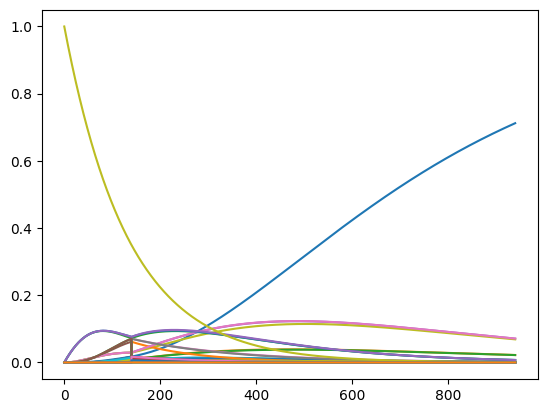

In [13]:
# label these plots with the states
fig, ax = plt.subplots()
for i in range(dim ** N):
    datas = []
    for j in range(len(states)):
        # print(np.real(states[j][i, i]))
        datas.append(np.real(states[j][i][i]))    
    ax.plot(time_list, datas)
# datas = []
# for i in range(len(states)- 12000):
#     print(np.real(states[i][0, 0])) 
#     datas.append(np.real(states[i][0, 0]))

# ax.plot(time_list[0:38032], datas)